### Environment Setup and Library Imports

This section of the code installs and imports the necessary libraries for creating and training a Deep Q-Network (DQN) in the Wireless Sensor Network (WSN) environment. The steps include:

- **Installation of Stable Baselines3**: The `stable-baselines3[extra]` package is installed to provide the DQN algorithm and other tools needed for reinforcement learning.
- **Importing Libraries**:
  - `gymnasium`: A toolkit for developing and comparing reinforcement learning algorithms.
  - `spaces` from `gymnasium`: For defining action and observation spaces.
  - `numpy`: For numerical operations.
  - `random`: For generating random numbers.
  - `scipy.stats.poisson`: For generating sensor positions based on a Poisson distribution.
  - `DQN` from `stable_baselines3`: For implementing the DQN algorithm.
  - `check_env` from `stable_baselines3.common.env_checker`: For validating the custom environment.

These imports set up the foundation for creating the WSN environment and training the DQN model.


In [ ]:
!pip install stable-baselines3[extra]

In [ ]:
import gymnasium
from gymnasium import spaces
import numpy as np
import random
from scipy.stats import poisson
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


### Custom Wireless Sensor Network (WSN) Environment Definition

This section of the code defines a custom environment for simulating a Wireless Sensor Network (WSN) using the `gymnasium` library. The environment is designed to support the development and testing of scheduling algorithms, particularly for reinforcement learning. The key components include:

- **Initialization (`__init__`)**: 
  - Sets up the environment parameters such as the number of sensors, sensor coverage, maximum steps per episode, and event generation threshold.
  - Initializes the sensor positions and internal state variables.
  - Defines the observation and action spaces.

- **Environment Reset (`reset`)**: 
  - Resets the environment at the start of each episode, including resetting the internal state variables and the sensor selection counts.

- **Step Function (`step`)**: 
  - Defines the environment's response to an agent's action, including event generation, sensor selection, reward calculation, and termination condition checks.

- **Sensor Position Generation (`_generate_sensor_positions`)**: 
  - Generates random sensor positions within the environment based on a Poisson distribution.

- **Render and Close Methods**: 
  - Placeholder methods for rendering and closing the environment.

This custom environment serves as the foundation for testing and developing intelligent scheduling strategies in a WSN context, with a focus on reinforcement learning applications.


In [ ]:
class WSNEnvironment(gymnasium.Env):

    metadata = {"render_modes": ["console"]}
    def __init__(self, num_sensors=13, sensor_coverage=0.4, max_steps=1000, threshold_prob=0.3):
        super(WSNEnvironment, self).__init__()

        # Environment parameters
        self.num_sensors = num_sensors
        self.sensor_coverage = sensor_coverage
        self.max_steps = max_steps
        self.threshold_prob = threshold_prob

        # Initialize the environment
        self.sensor_positions, self.num_points = self._generate_sensor_positions()

        # Define observation space
        self.observation_space = spaces.Box(low=0, high=1000, shape=(self.num_points, 3), dtype=np.float32)

        # Define action space
        self.action_space = spaces.Discrete(self.num_points)  # Select sensor index

        # Internal state variables
        self.step_count = 0

        # information dictionary
        self.info = {}

        # the generated event
        self.event = None

        # Number of generated events
        self.generated_events = 0

    def reset(self, seed=0):
        # Initialize the environment at the start of each episode
        self.step_count = 0
        self.generated_events = 0
        self.info = {'captured': 0, 'non-captured': 0}

        for i in range(self.num_points):
            self.info['sensor '+str(i)] = set()
            # reset the number of selection for each sensor to 0
            self.sensor_positions[i,-1] = 0
        return self.sensor_positions, self.info

    def step(self, action):
        # Execute one step in the environment
        truncated = bool(self.step_count > self.max_steps)
        terminated = False
        reward = 0

        # Check termination condition
        if truncated:
            terminated = True
            return self.sensor_positions, reward, terminated, truncated, self.info

        self.event = None

        # we flip a coin to get a probability and if it exceeds threshold we generate an event
        prob_flip_coin = random.uniform(0, 1)

        if prob_flip_coin >= self.threshold_prob:
            self.event = 1
        else:
            self.event = 0

        if self.event == 1:

            self.generated_events += 1

            # Generate event location
            event_location = np.random.uniform(low=0, high=1, size=(2,))

            # detect the sensors near that event
            for i in range(self.num_points):
                # calculate the distance between the sensor and the event
                distance = np.linalg.norm(event_location - self.sensor_positions[i,:2])

                # adding the event to the sensor events buffer in case its under the coverage
                # the event is represented with a tuple (event, the step count in the episode)
                if distance <= self.sensor_coverage:
                    self.info['sensor '+str(i)].add((self.event, self.step_count))

            # check the sensor buffer of the selected action
            selected_buffer = self.info['sensor '+str(action)]
            number_captured_events = len(selected_buffer)

            #update the observation space
            self.sensor_positions[action, 2] += 1

            if  number_captured_events == 0:
              reward = -0.4

            else:
              #calculate the reward
              temp = 0
              # looping through events in the selected buffer's set
              for x in selected_buffer:
                #age of info
                AoI = self.step_count - x[-1]
                if AoI == 0: temp = 1
                else: temp += 1/AoI


              reward = temp

              # remove the selected events from the other buffers
              for i in range(self.num_points):
                #skip the selected sensor's buffer
                if i != action :
                  buffer = self.info['sensor '+str(i)]
                  buffer.difference_update(selected_buffer)

              #clear the buffer of the selected sensor
              selected_buffer.clear()

              #update the info dict
              self.info['captured'] += number_captured_events

        #no generated event
        else:  reward = 0

        # calculate the non-captured event in case the episode is done
        if self.step_count == self.max_steps:
            self.info['non-captured'] = self.generated_events - self.info['captured']

        self.step_count += 1

        # Return the next observation, reward, termination signal, and additional information
        return self.sensor_positions, reward, terminated, truncated, self.info

    def _generate_sensor_positions(self):

        # Set a fixed random seed for reproducibility
        np.random.seed(42)

        # Define the intensity (lambda) for the Poisson process
        intensity = self.num_sensors / (1 * 1)  # Adjust as needed based on the size of the space

        # Generate the number of points based on a Poisson distribution
        num_points = poisson(intensity).rvs()

        # Generate the sensor positions uniformly at random within the space
        sensor_positions = np.random.uniform(low=0, high=1, size=(num_points, 2))

        # Create a new column of zeros with the same number of sensors to calculate the number of pulling for each one
        zeros_column = np.zeros((num_points, 1))

        # Concatenate the original array with the new column of zeros
        sensor_positions_with_zeros = np.hstack((sensor_positions, zeros_column))


        return sensor_positions_with_zeros.astype(np.float32), num_points

    def render(self):
        pass

    def close(self):
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = WSNEnvironment()

In [ ]:
env.sensor_positions

array([[0.7319939 , 0.5986585 , 0.        ],
       [0.15601864, 0.15599452, 0.        ],
       [0.05808361, 0.8661761 , 0.        ],
       [0.601115  , 0.7080726 , 0.        ],
       [0.02058449, 0.96990985, 0.        ],
       [0.83244264, 0.21233912, 0.        ],
       [0.18182497, 0.1834045 , 0.        ],
       [0.30424225, 0.52475643, 0.        ],
       [0.43194503, 0.29122913, 0.        ],
       [0.6118529 , 0.13949387, 0.        ],
       [0.29214466, 0.36636186, 0.        ],
       [0.45606998, 0.785176  , 0.        ]], dtype=float32)

### Baseline Random Scheduler Simulation

This section of the code simulates a baseline random scheduler in the custom Wireless Sensor Network (WSN) environment. The steps involved are:

- **Initialization of simulation parameters**, including the number of episodes and a list to store scores.
- **Execution of the random scheduler**:
  - For each episode, the environment is reset, and actions are selected randomly.
  - The agent accumulates rewards based on the actions taken and the events captured by the sensors.
  - The episode ends when the termination condition is met (maximum steps reached).
- **Recording and printing of scores**:
  - After each episode, the total score is recorded and printed along with information about captured and non-captured events.
- **Calculation and display of the average score** across all episodes, providing a baseline measure of performance.

This baseline simulation is crucial for comparing the performance of more advanced scheduling algorithms, such as those utilizing reinforcement learning.


In [ ]:
episodes = 20
scores = []

for episode in range(1, episodes+1):
    state, info = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        done = terminated or truncated

    scores.append(score)
    print('Episode:{}\t Score:{:.2f} \t{}'.format(episode, score, info))

# Print average score
print('Average Score:', np.mean(scores))

Episode:1	 Score:272.79 	{'captured': 668, 'non-captured': 10, 'sensor 0': {(1, 986), (1, 994), (1, 978), (1, 970), (1, 999)}, 'sensor 1': {(1, 1000)}, 'sensor 2': set(), 'sensor 3': {(1, 986), (1, 970), (1, 999), (1, 994)}, 'sensor 4': set(), 'sensor 5': {(1, 994), (1, 978)}, 'sensor 6': {(1, 1000)}, 'sensor 7': {(1, 1000), (1, 999)}, 'sensor 8': {(1, 999), (1, 1000)}, 'sensor 9': set(), 'sensor 10': {(1, 999), (1, 1000)}, 'sensor 11': {(1, 986), (1, 999)}}
Episode:2	 Score:301.38 	{'captured': 682, 'non-captured': 6, 'sensor 0': {(1, 999), (1, 1000)}, 'sensor 1': set(), 'sensor 2': set(), 'sensor 3': {(1, 1000)}, 'sensor 4': set(), 'sensor 5': {(1, 999)}, 'sensor 6': set(), 'sensor 7': set(), 'sensor 8': set(), 'sensor 9': {(1, 999)}, 'sensor 10': set(), 'sensor 11': {(1, 1000)}}
Episode:3	 Score:304.80 	{'captured': 704, 'non-captured': 8, 'sensor 0': {(1, 1000)}, 'sensor 1': {(1, 999)}, 'sensor 2': {(1, 1000), (1, 994)}, 'sensor 3': {(1, 1000)}, 'sensor 4': {(1, 994)}, 'sensor 5': 

In [ ]:
env.sensor_positions

array([[7.3199391e-01, 5.9865850e-01, 4.6000000e+01],
       [1.5601864e-01, 1.5599452e-01, 5.6000000e+01],
       [5.8083612e-02, 8.6617613e-01, 4.7000000e+01],
       [6.0111499e-01, 7.0807260e-01, 5.0000000e+01],
       [2.0584494e-02, 9.6990985e-01, 5.9000000e+01],
       [8.3244264e-01, 2.1233912e-01, 6.0000000e+01],
       [1.8182497e-01, 1.8340451e-01, 4.7000000e+01],
       [3.0424225e-01, 5.2475643e-01, 7.1000000e+01],
       [4.3194503e-01, 2.9122913e-01, 6.6000000e+01],
       [6.1185288e-01, 1.3949387e-01, 5.7000000e+01],
       [2.9214466e-01, 3.6636186e-01, 5.5000000e+01],
       [4.5606998e-01, 7.8517598e-01, 5.5000000e+01]], dtype=float32)

In [ ]:
check_env(env, warn=True, skip_render_check=True)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:244: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


### Training the Deep Q-Network (DQN) Model

This section of the code initializes and trains a Deep Q-Network (DQN) model using the custom Wireless Sensor Network (WSN) environment. The steps include:

- **Model Initialization**:
  - The DQN model is initialized with an `MlpPolicy`, which is a multilayer perceptron policy. This policy defines the neural network architecture used by the DQN to approximate the Q-values.
  - The custom WSN environment (`env`) is passed to the model, and `verbose=1` enables detailed logging of the training process.

- **Model Training**:
  - The DQN model is trained for `100,000` timesteps. During training, the model interacts with the environment, selecting actions, receiving rewards, and updating its Q-values to learn an optimal policy.
  - The `log_interval=4` parameter specifies that training progress should be logged every 4 timesteps, providing regular updates on the learning process.

This training step is critical for enabling the DQN model to learn effective scheduling strategies in the WSN environment, optimizing sensor selection and event capture.


In [ ]:
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000, log_interval=4)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 294      |
|    exploration_rate | 0.619    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4604     |
|    time_elapsed     | 0        |
|    total_timesteps  | 4008     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 290      |
|    exploration_rate | 0.238    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4656     |
|    time_elapsed     | 1        |
|    total_timesteps  | 8016     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 290   

### Evaluation of the Trained DQN Model

This section of the code evaluates the performance of the trained Deep Q-Network (DQN) model in the Wireless Sensor Network (WSN) environment. The evaluation process includes:

- **Initialization of evaluation parameters**, including the number of episodes and a list to store scores.
- **Execution of the DQN model**:
  - For each episode, the environment is reset, and the DQN model predicts actions based on the current state.
  - The agent accumulates rewards by selecting actions, and the episode continues until the termination condition is met (maximum steps or other criteria).
  - The total score for each episode is recorded.
- **Recording and printing of scores**:
  - After each episode, the score is printed alongside the information about captured and non-captured events.
- **Calculation and display of the average score** across all episodes, providing a measure of the DQN model's effectiveness in optimizing sensor scheduling.

This evaluation step is essential for assessing how well the DQN model has learned and its ability to outperform baseline scheduling strategies.


In [ ]:
episodes = 20
scores = []

for episode in range(1, episodes+1):
    state, info = env.reset()
    done = False
    score = 0

    while not done:
        action = model.predict(state, deterministic=True)
        n_state, reward, terminated, truncated, info = env.step(action[0])
        score += reward
        done = terminated or truncated
        state = n_state

    scores.append(score)
    print('Episode:{}\t Score:{:.2f} \t{}'.format(episode, score, info))

# Print average score
print('Average Score:', np.mean(scores))

Episode:1	 Score:317.66 	{'captured': 651, 'non-captured': 43, 'sensor 0': {(1, 626), (1, 490), (1, 560), (1, 842), (1, 781), (1, 218), (1, 671), (1, 622), (1, 994), (1, 843), (1, 997), (1, 771)}, 'sensor 1': {(1, 577), (1, 249)}, 'sensor 2': {(1, 632), (1, 644), (1, 854), (1, 561), (1, 439), (1, 451), (1, 42), (1, 890), (1, 835), (1, 292), (1, 844), (1, 795), (1, 432), (1, 612), (1, 267), (1, 807), (1, 999), (1, 657), (1, 837), (1, 309), (1, 617), (1, 385)}, 'sensor 3': set(), 'sensor 4': {(1, 632), (1, 644), (1, 854), (1, 561), (1, 439), (1, 451), (1, 42), (1, 890), (1, 835), (1, 292), (1, 844), (1, 795), (1, 432), (1, 612), (1, 267), (1, 807), (1, 999), (1, 657), (1, 837), (1, 309), (1, 617), (1, 385)}, 'sensor 5': {(1, 671), (1, 560), (1, 994), (1, 843), (1, 997), (1, 842), (1, 781), (1, 218)}, 'sensor 6': {(1, 577), (1, 249)}, 'sensor 7': set(), 'sensor 8': set(), 'sensor 9': {(1, 997)}, 'sensor 10': set(), 'sensor 11': {(1, 632), (1, 844), (1, 795), (1, 612), (1, 267), (1, 999), 

In [ ]:
env.sensor_positions

array([[7.3199391e-01, 5.9865850e-01, 2.1000000e+01],
       [1.5601864e-01, 1.5599452e-01, 1.0000000e+00],
       [5.8083612e-02, 8.6617613e-01, 0.0000000e+00],
       [6.0111499e-01, 7.0807260e-01, 2.0400000e+02],
       [2.0584494e-02, 9.6990985e-01, 0.0000000e+00],
       [8.3244264e-01, 2.1233912e-01, 0.0000000e+00],
       [1.8182497e-01, 1.8340451e-01, 0.0000000e+00],
       [3.0424225e-01, 5.2475643e-01, 1.2500000e+02],
       [4.3194503e-01, 2.9122913e-01, 0.0000000e+00],
       [6.1185288e-01, 1.3949387e-01, 1.4300000e+02],
       [2.9214466e-01, 3.6636186e-01, 2.0700000e+02],
       [4.5606998e-01, 7.8517598e-01, 2.2000000e+01]], dtype=float32)

### Time Latency Analysis for DQN Scheduler

This section of the code analyzes and visualizes the time latency for events captured by the trained Deep Q-Network (DQN) scheduler in the Wireless Sensor Network (WSN) environment. The process includes:

- **Environment reset and initialization** to prepare for the latency analysis.
- **Latency data collection**:
  - For each step, the DQN model predicts an action, and the latency for each event captured by the selected sensor is recorded.
  - Latency is calculated as the difference between the current step count and the event occurrence time.
- **Calculation of average, minimum, and maximum latency values** to provide insights into the DQN scheduler's performance in minimizing latency.
- **Plotting the time latency**:
  - A line plot is generated to visualize the evolution of time latency for captured events across the episode.
  - The plot includes labeled axes and a legend for clarity, and the plot is displayed with a tight layout for better visualization.

This analysis helps to assess the efficiency of the DQN scheduler in minimizing the latency of captured events, providing a basis for comparison with other scheduling strategies.


Average Time latency: 7.49 min: 1.00 max: 133.00


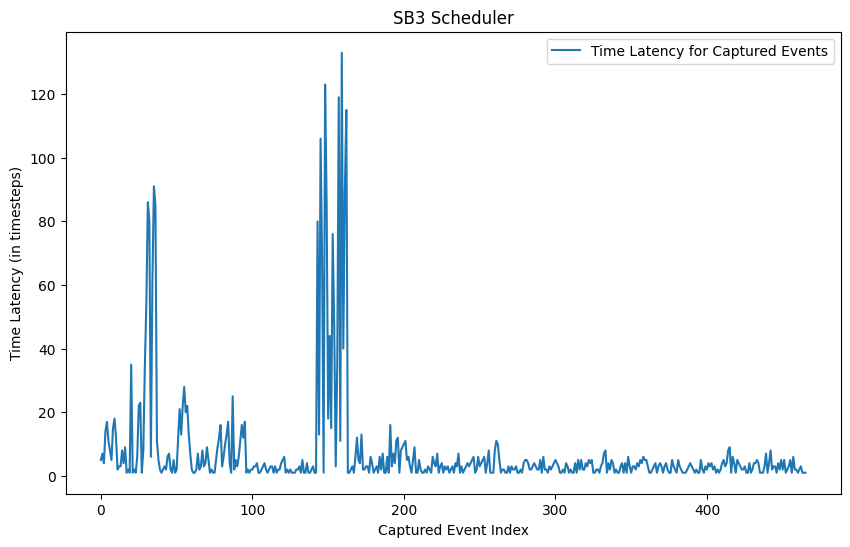

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

obs, info = env.reset()

captured_latency = []  # List to store time latency for captured events

for step in range(env.max_steps):
    action = model.predict(state, deterministic=True)

    if (info['sensor '+ str(action[0])] != set()):
      for event in info['sensor '+ str(action[0])]:
        time_latency = env.step_count - event[-1]
        captured_latency.append(time_latency)

    n_obs, reward, terminated, truncated, info = env.step(action[0])
    state = n_obs

print('Average Time latency: {:.2f} min: {:.2f} max: {:.2f}'.format(np.mean(captured_latency), min(captured_latency), max(captured_latency)))

# Plot the evolution of time latency
plt.figure(figsize=(10, 6))
plt.plot(captured_latency, label='Time Latency for Captured Events')
plt.title('SB3 Scheduler')
plt.xlabel('Captured Event Index')
plt.ylabel('Time Latency (in timesteps)')
plt.legend()
plt.show()
plt.tight_layout()